# Simulation plugins


![](https://i.imgur.com/RSOTDIN.png)

Sparameters are common in RF and photonic simulation.



```bash

         top view
              ________________________________
             |                               |
             | xmargin_left                  | port_extension
             |<--------->       port_margin ||<-->
          o2_|___________          _________||_o3
             |           \        /          |
             |            \      /           |
             |             ======            |
             |            /      \           |
          o1_|___________/        \__________|_o4
             |   |                 <-------->|
             |   |ymargin_bot   xmargin_right|
             |   |                           |
             |___|___________________________|

        side view
              ________________________________
             |                     |         |
             |                     |         |
             |                   zmargin_top |
             |xmargin_left         |         |
             |<---> _____         _|___      |
             |     |     |       |     |     |
             |     |     |       |     |     |
             |     |_____|       |_____|     |
             |       |                       |
             |       |                       |
             |       |zmargin_bot            |
             |       |                       |
             |_______|_______________________|



```

We are going to simulate a MZI interferometer circuit. For that we need to simulate each of the component Sparameters in Meep and then use a linear circuit solver to solve the Sparameters for the circuit.

## Mode solver


In [1]:
from gdsfactory.simulation.modes import find_modes_waveguide

def silicon_index(wl):
    """ a rudimentary silicon refractive index model """
    a = 0.2411478522088102
    b = 3.3229394315868976
    return a / wl + b

nm = 1e-3
wl = 1.55
w = 500*nm
modes = find_modes_waveguide(wavelength=wl, wg_width=w, mode_number=1, wg_thickness=0.22, slab_thickness=0.0, ncore=silicon_index(wl), nclad=1.4)

2022-11-13 19:51:46.309 | INFO     | gdsfactory.config:<module>:45 - Load '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdsfactory' 6.0.1
/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-13 19:51:49.048 | INFO     | gdsfactory.simulation.gmeep:<module>:32 - Meep '1.24.0' installed at ['/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep']


In [2]:
mode = modes[1]

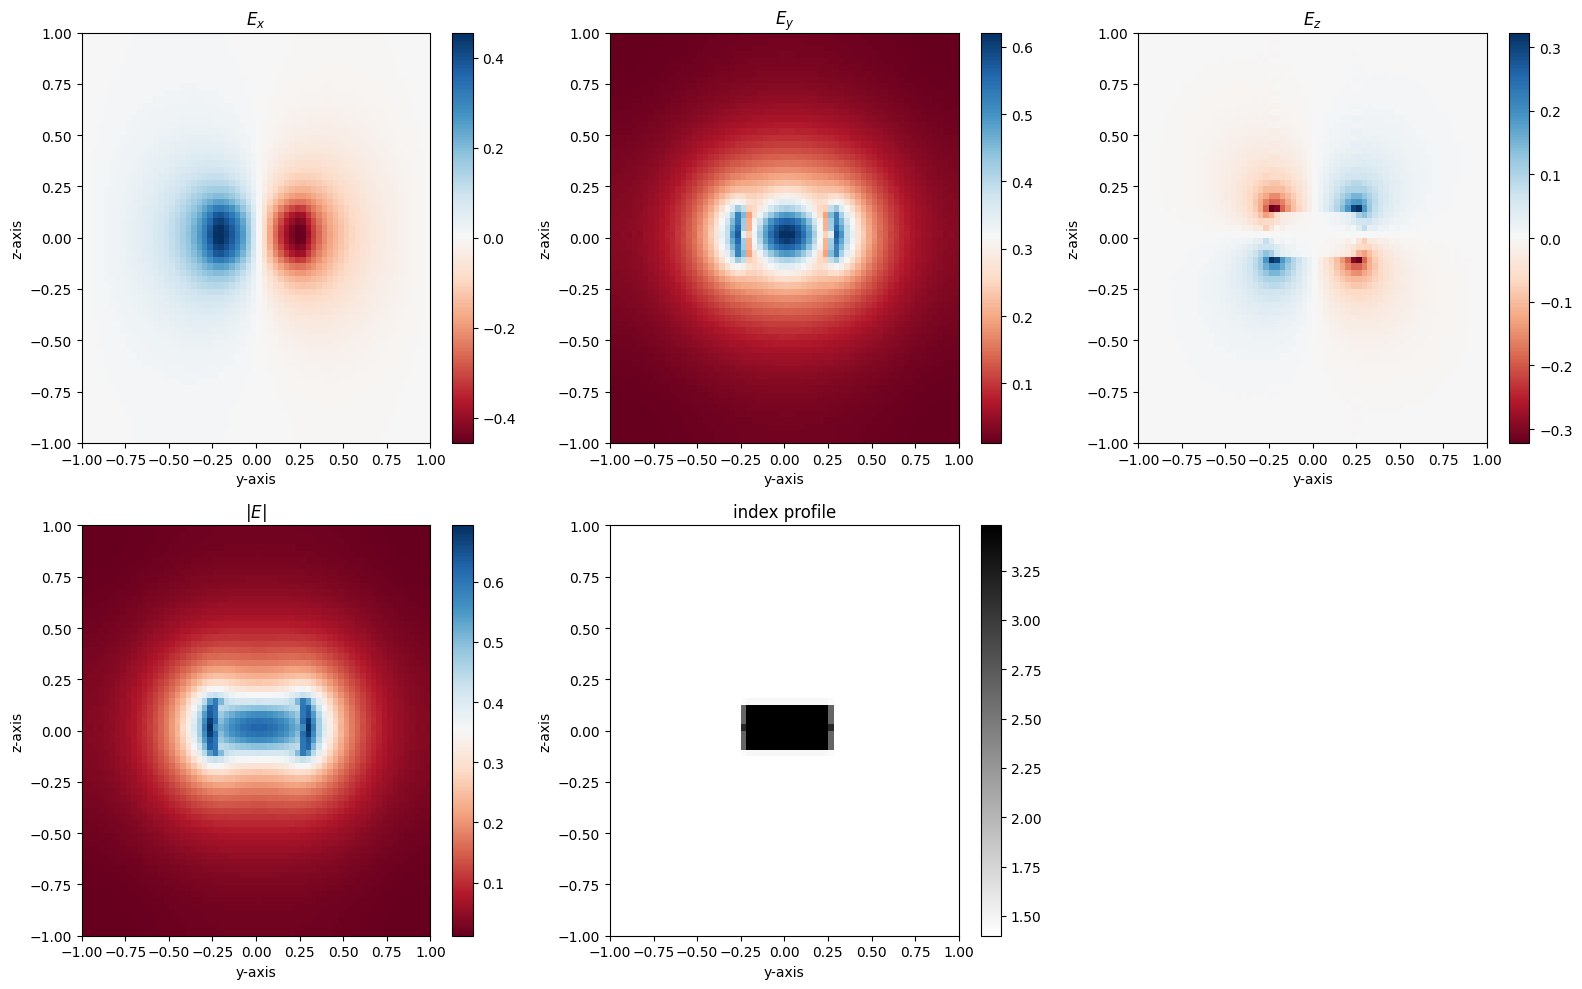

In [3]:
mode.plot_e_all()

In [4]:
mode.neff

2.4409489585196966

## FDTD

In [5]:
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation as sim
import gdsfactory as gf

import ubcpdk as pdk

2022-11-13 19:51:50.908 | INFO     | ubcpdk:<module>:36 - Found UBCpdk '1.8.0' installed at PosixPath('/usr/local/google/home/jmatres/ubc/ubcpdk')


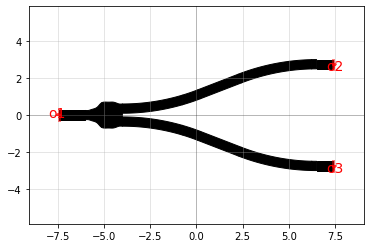

ebeam_y_1550: uid cf0e06a7, ports ['o1', 'o2', 'o3'], references [], 18 polygons

In [6]:
c = pdk.components.ebeam_y_1550()
c.unlock()
c.auto_rename_ports()
c

In [7]:
c.ports

{'o1': Port (name o1, center [-7.4  0. ], width 0.5, orientation 180, layer (1, 0), port_type optical),
 'o2': Port (name o2, center [7.4  2.75], width 0.5, orientation 0, layer (1, 0), port_type optical),
 'o3': Port (name o3, center [ 7.4  -2.75], width 0.5, orientation 0, layer (1, 0), port_type optical)}

`run=False` only plots the simulations for you to review that is set up **correctly**

[19:51:51] INFO     Using client version: 1.7.1                                ]8;id=499998;file:///usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=414468;file:///usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/tidy3d/__init__.py#95\95]8;;\

2022-11-13 19:51:51.998 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.7.1' installed at ['/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/tidy3d']
/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep/__init__.py:4494: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


<Figure size 432x288 with 1 Axes>

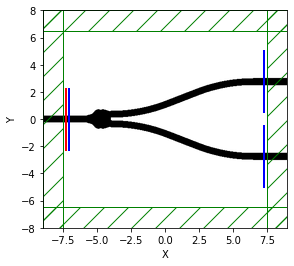

In [8]:
df = gm.write_sparameters_meep(c, run=False)

In [9]:
df = gm.write_sparameters_meep(c, run=True)

2022-11-13 19:51:52.779 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:341 - Simulation loaded from PosixPath('/usr/local/google/home/jmatres/ubc/sparameters/ebeam_y_1550_1f494ca0.npz')


<Figure size 432x288 with 1 Axes>

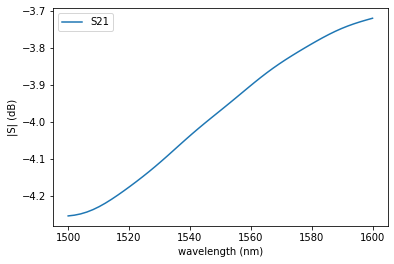

In [10]:
sim.plot.plot_sparameters(df, keys=['s21m'], with_simpler_input_keys=True)

## 2.5D FDTD

For faster simulations you can do an effective mode approximation, to compute the mode of the slab and run a 2D simulation to speed your [simulations](https://www.lumerical.com/learn/whitepapers/lumericals-2-5d-fdtd-propagation-method/)

In [11]:
ncore = sim.get_effective_indices(
            ncore=3.4777,
            ncladding=1.444,
            nsubstrate=1.444,
            thickness=0.22,
            wavelength=1.55,
            polarization="te",
        )[0]
ncore

2.8494636999424405

In [12]:
df2d = gm.write_sparameters_meep(c, resolution=20, is_3d=False, material_name_to_meep=dict(si=ncore))

2022-11-13 19:51:52.933 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:341 - Simulation loaded from PosixPath('/usr/local/google/home/jmatres/ubc/sparameters/ebeam_y_1550_76acf988.npz')


<Figure size 432x288 with 1 Axes>

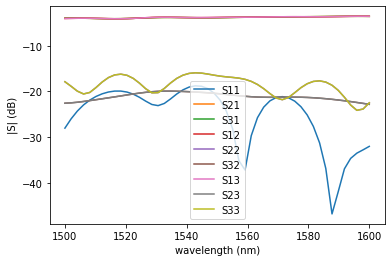

In [13]:
gf.simulation.plot.plot_sparameters(df2d)

<Figure size 432x288 with 1 Axes>

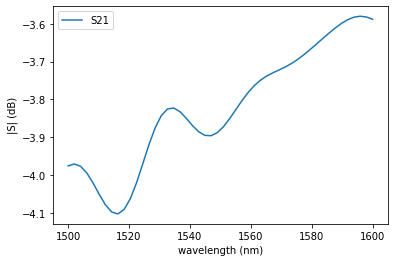

<Figure size 432x288 with 1 Axes>

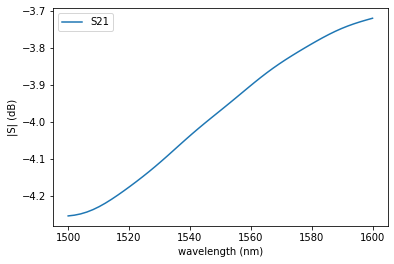

In [14]:
sim.plot.plot_sparameters(df2d, keys=['s21m'], with_simpler_input_keys=True)
sim.plot.plot_sparameters(df, keys=['s21m'], with_simpler_input_keys=True)

For a small taper S21 (Transmission) is around 0dB (100% transmission)

## Port symmetries

You can save some simulations in reciprocal devices.
If the device looks the same going from in -> out as out -> in, we only need to run one simulation

<Figure size 432x288 with 1 Axes>

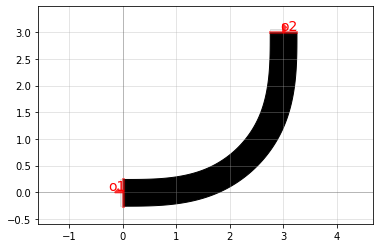

<Figure size 432x288 with 1 Axes>

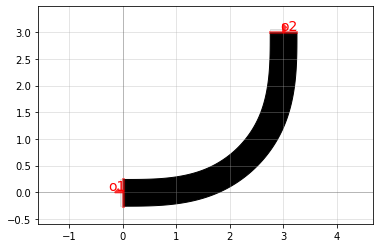

bend_euler_radius3: uid 8fe1bd94, ports ['o1', 'o2'], references [], 2 polygons

In [15]:
c = gf.components.bend_euler(radius=3)
c

/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep/__init__.py:4494: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


<Figure size 432x288 with 1 Axes>

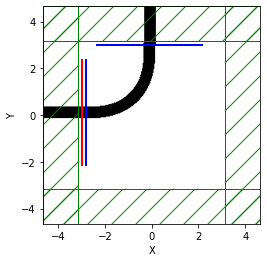

In [16]:
df = gm.write_sparameters_meep_1x1_bend90(c, run=False)

In [17]:
df = gm.write_sparameters_meep_1x1_bend90(c, run=True)

2022-11-13 19:51:55.083 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:341 - Simulation loaded from PosixPath('/usr/local/google/home/jmatres/ubc/sparameters/bend_euler_radius3_6ad1d010.npz')


<Figure size 432x288 with 1 Axes>

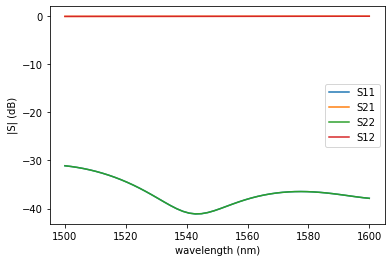

In [18]:
gf.simulation.plot.plot_sparameters(df)

<Figure size 432x288 with 1 Axes>

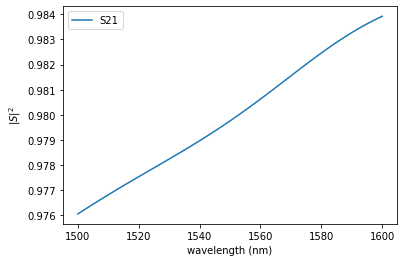

In [19]:
gf.simulation.plot.plot_sparameters(df, keys=("s21m",), logscale=False, with_simpler_input_keys=True)

<Figure size 432x288 with 1 Axes>

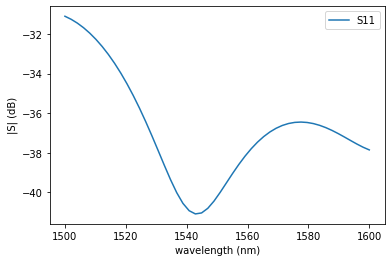

In [20]:
gf.simulation.plot.plot_sparameters(df, keys=("s11m",), with_simpler_input_keys=True)

<Figure size 432x288 with 1 Axes>

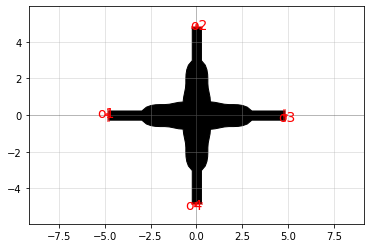

<Figure size 432x288 with 1 Axes>

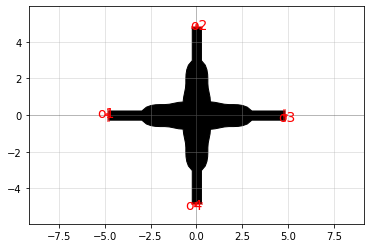

ebeam_crossing4_7e264905: uid 8ad67fb9, ports ['o1', 'o3', 'o4', 'o2'], references [], 2 polygons

In [21]:
c = pdk.components.ebeam_crossing4(decorator=gf.port.auto_rename_ports)
c

Here are the port symmetries for a crossing

```python
port_symmetries = {
    "o1": {
        "s11": ["s22", "s33", "s44"],
        "s21": ["s12", "s34", "s43"],
        "s31": ["s13", "s24", "s42"],
        "s41": ["s14", "s23", "s32"],
    }
}
```

/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep/__init__.py:4494: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


<Figure size 432x288 with 1 Axes>

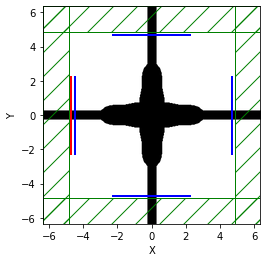

In [22]:
df = gm.write_sparameters_meep(
    c,
    resolution=20,
    ymargin=0,
    port_symmetries=gm.port_symmetries.port_symmetries_crossing,
    run=False,
)

In [23]:
df = gm.write_sparameters_meep(
    c,
    resolution=20,
    ymargin=0,
    port_symmetries=gm.port_symmetries.port_symmetries_crossing,
    run=True,
)

2022-11-13 19:51:57.358 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:341 - Simulation loaded from PosixPath('/usr/local/google/home/jmatres/ubc/sparameters/ebeam_crossing4_7e264905_216d7d7a.npz')


<Figure size 432x288 with 1 Axes>

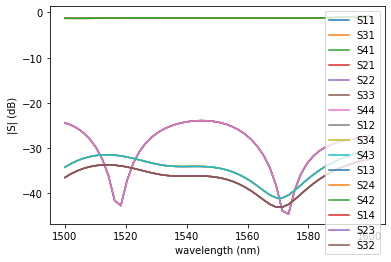

In [24]:
gm.plot.plot_sparameters(df)

<Figure size 432x288 with 1 Axes>

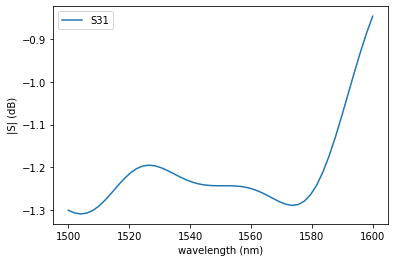

In [25]:
gm.plot.plot_sparameters(df, keys=("s31m",), with_simpler_input_keys=True)

## Multicore (MPI)

You can divide each simulation into multiple cores thanks to [MPI (message passing interface)](https://en.wikipedia.org/wiki/Message_Passing_Interface)

Lets try to reproduce the coupler results from the [Meep docs](https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/)

According to the simulations in the doc to get a 3dB (50%/50%) splitter you need 150nm over 8um

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import gdsfactory as gf
import gdsfactory.simulation as sim
import gdsfactory.simulation.gmeep as gm

<Figure size 432x288 with 1 Axes>

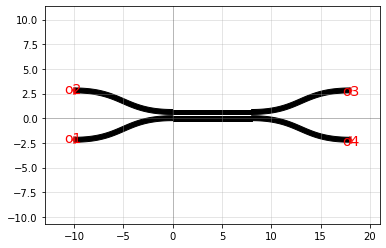

<Figure size 432x288 with 1 Axes>

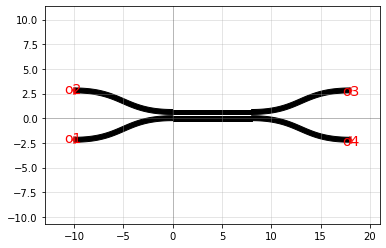

coupler_gap0p13_length8: uid db1fdf66, ports ['o1', 'o2', 'o3', 'o4'], references [], 7 polygons

In [27]:
c = gf.components.coupler(length=8, gap=0.13)
c

/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep/__init__.py:4494: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


<meep.simulation.Simulation object at 0x7fb7f4d89040>

<Figure size 432x288 with 1 Axes>

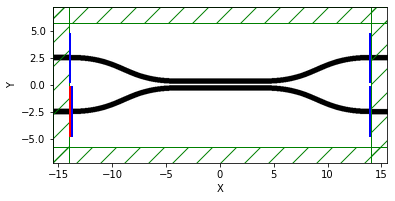

In [28]:
gm.write_sparameters_meep(component=c, run=False)

In [29]:
filepath = gm.write_sparameters_meep_mpi(
    component=c,
    cores=4,
    resolution=30,
)

2022-11-13 19:52:01.683 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:147 - Simulation PosixPath('/usr/local/google/home/jmatres/ubc/sparameters/coupler_gap0p13_length8_e8c7ce5e.npz') already exists


In [31]:
sp = np.load(filepath)

<Figure size 432x288 with 1 Axes>

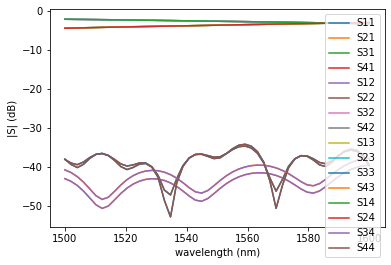

In [32]:
gf.simulation.plot.plot_sparameters(sp)

<Figure size 432x288 with 1 Axes>

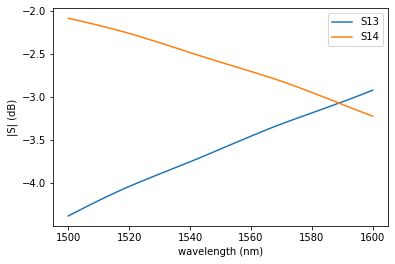

In [33]:
gf.simulation.plot.plot_sparameters(sp, keys=["s13m", "s14m"], with_simpler_input_keys=True)

## Batch

You can also run a batch of multicore simulations

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdsfactory as gf

import gdsfactory.simulation as sim
import gdsfactory.simulation.gmeep as gm

In [35]:
c = gf.components.straight(length=3.1)

/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep/__init__.py:4494: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


<meep.simulation.Simulation object at 0x7fb7f4ca79d0>

<Figure size 432x288 with 1 Axes>

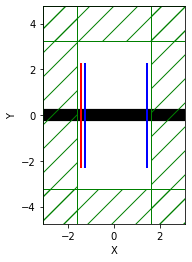

In [36]:
gm.write_sparameters_meep(c, ymargin=3, run=False)

In [37]:
c1_dict = {"component": c, "ymargin": 3}
jobs = [
    c1_dict,
]

filepaths = gm.write_sparameters_meep_batch_1x1(
    jobs=jobs,
    cores_per_run=4,
    total_cores=8,
    lazy_parallelism=True,
)

2022-11-13 19:52:56.858 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:136 - Simulation PosixPath('/usr/local/google/home/jmatres/ubc/sparameters/straight_length3p1_664ba415.npz') not found. Adding it to the queue
2022-11-13 19:52:56.859 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:144 - Running 1 simulations
2022-11-13 19:52:56.860 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:145 - total_cores = 8 with cores_per_run = 4
2022-11-13 19:52:56.860 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:146 - Running 1 batches with up to 2 jobs each.


  0%|          | 0/1 [00:00<?, ?it/s]

2022-11-13 19:52:56.882 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:157 - Task 0 of batch 0 is job 0
2022-11-13 19:52:56.885 | INFO     | gdsfactory.component:write_gds:1473 - Write GDS to '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdslib/sp/temp/write_sparameters_meep_mpi_0.gds'
2022-11-13 19:52:56.906 | INFO     | gdsfactory.component:write_gds_with_metadata:1481 - Write YAML metadata to '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdslib/sp/temp/write_sparameters_meep_mpi_0.yml'
2022-11-13 19:52:56.907 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:195 - mpirun -np 4 /usr/local/google/home/jmatres/mambaforge/bin/python /usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdslib/sp/temp/write_sparameters_meep_mpi_0.py
2022-11-13 19:52:56.908 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:writ

{'component': straight_length3p1: uid 4cee4e77, ports ['o1', 'o2'], references [], 2 polygons,
 'ymargin': 3}
[19:53:00] INFO     Using client version: 1.7.1                   __init__.py:95
[19:53:00] INFO     Using client version: 1.7.1                   __init__.py:95
[19:53:01] INFO     Using client version: 1.7.1                   __init__.py:95
[19:53:01] INFO     Using client version: 1.7.1                   __init__.py:95

Elapsed run time = 10.6914 s

Elapsed run time = 10.7653 s

Elapsed run time = 10.9074 s

Elapsed run time = 11.0545 s

2022-11-13 19:52:57.432 | INFO     | gdsfactory.config:<module>:45 - Load '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdsfactory' 6.0.1
2022-11-13 19:52:57.432 | INFO     | gdsfactory.config:<module>:45 - Load '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdsfactory' 6.0.1
2022-11-13 19:52:57.446 | INFO     | gdsfactory.config:<module>:45 - Load '/usr/local/google/home/jmatres/mambaforge/li

<Figure size 432x288 with 1 Axes>

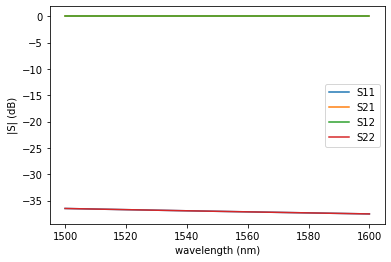

In [41]:
sp = np.load(filepaths[0])
gf.simulation.plot.plot_sparameters(sp)

<Figure size 432x288 with 1 Axes>

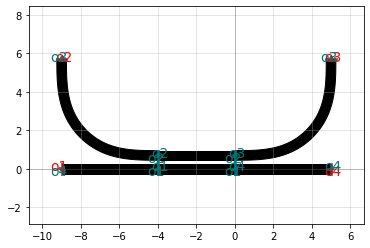

<Figure size 432x288 with 1 Axes>

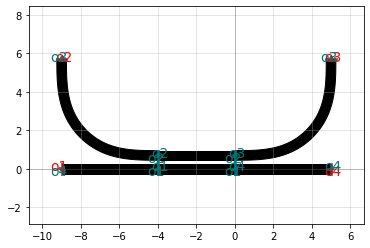

coupler_ring: uid 32edd2de, ports ['o2', 'o1', 'o3', 'o4'], references ['coupler90_1', 'coupler90_2', 'coupler_straight_1'], 0 polygons

In [42]:
c = gf.components.coupler_ring()
c

/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep/__init__.py:4494: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


<meep.simulation.Simulation object at 0x7fbc78a240a0>

<Figure size 432x288 with 1 Axes>

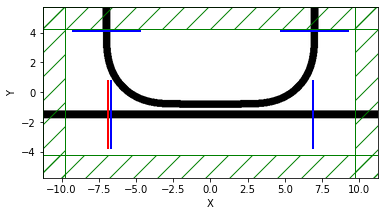

In [43]:
p = 2.5
gm.write_sparameters_meep(c, ymargin=0, ymargin_bot=p, xmargin=p, run=False)

In [44]:
c1_dict = dict(
    component=c,
    ymargin=0,
    ymargin_bot=p,
    xmargin=p,
)
jobs = [c1_dict]

filepaths = gm.write_sparameters_meep_batch(
    jobs=jobs,
    cores_per_run=4,
    total_cores=8,
    delete_temp_files=False,
    lazy_parallelism=True,
)

2022-11-13 19:53:57.508 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:136 - Simulation PosixPath('/usr/local/google/home/jmatres/ubc/sparameters/coupler_ring_d97f3207.npz') not found. Adding it to the queue
2022-11-13 19:53:57.510 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:144 - Running 1 simulations
2022-11-13 19:53:57.511 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:145 - total_cores = 8 with cores_per_run = 4
2022-11-13 19:53:57.511 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:146 - Running 1 batches with up to 2 jobs each.


  0%|          | 0/1 [00:00<?, ?it/s]

2022-11-13 19:53:57.532 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:157 - Task 0 of batch 0 is job 0
2022-11-13 19:53:57.538 | INFO     | gdsfactory.component:write_gds:1473 - Write GDS to '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdslib/sp/temp/write_sparameters_meep_mpi_0.gds'
2022-11-13 19:53:57.581 | INFO     | gdsfactory.component:write_gds_with_metadata:1481 - Write YAML metadata to '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdslib/sp/temp/write_sparameters_meep_mpi_0.yml'
2022-11-13 19:53:57.582 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:195 - mpirun -np 4 /usr/local/google/home/jmatres/mambaforge/bin/python /usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdslib/sp/temp/write_sparameters_meep_mpi_0.py
2022-11-13 19:53:57.583 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:writ

{'component': coupler_ring: uid 32edd2de, ports ['o2', 'o1', 'o3', 'o4'], references ['coupler90_1', 'coupler90_2', 'coupler_straight_1'], 0 polygons,
 'xmargin': 2.5,
 'ymargin': 0,
 'ymargin_bot': 2.5}
[19:54:01] INFO     Using client version: 1.7.1                   __init__.py:95
[19:54:01] INFO     Using client version: 1.7.1                   __init__.py:95
[19:54:01] INFO     Using client version: 1.7.1                   __init__.py:95
[19:54:01] INFO     Using client version: 1.7.1                   __init__.py:95

Elapsed run time = 209.1860 s

Elapsed run time = 216.9497 s

Elapsed run time = 217.6104 s

Elapsed run time = 221.2945 s

2022-11-13 19:53:58.114 | INFO     | gdsfactory.config:<module>:45 - Load '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdsfactory' 6.0.1
2022-11-13 19:53:58.114 | INFO     | gdsfactory.config:<module>:45 - Load '/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/gdsfactory' 6.0.1
2022-11-13 19:53:58.1

In [46]:
sp = np.load(filepaths[0])

<Figure size 432x288 with 1 Axes>

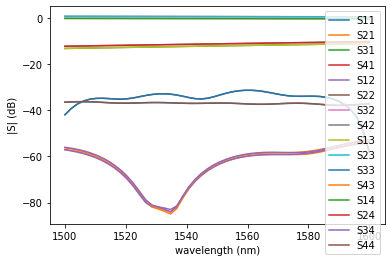

In [47]:
gm.plot.plot_sparameters(sp)

<Figure size 432x288 with 1 Axes>

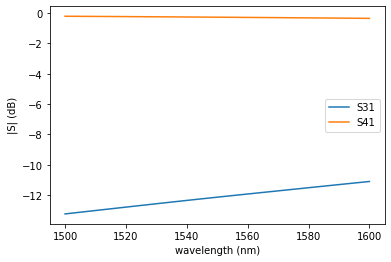

In [48]:
gm.plot.plot_sparameters(sp, keys=["s31m", "s41m"], with_simpler_input_keys=True)

<Figure size 432x288 with 1 Axes>

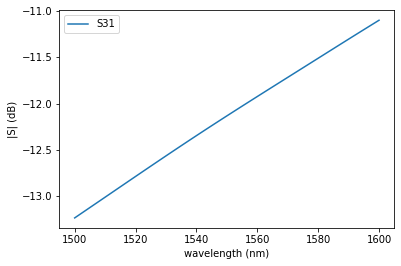

In [49]:
gm.plot.plot_sparameters(sp, keys=["s31m"], with_simpler_input_keys=True)

<Figure size 432x288 with 1 Axes>

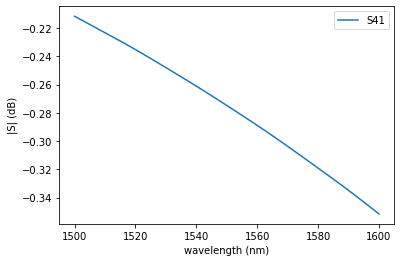

In [50]:
gm.plot.plot_sparameters(sp, keys=["s41m"], with_simpler_input_keys=True)

## 3D rendering

[20:56:06] INFO     Generating grammar tables from /usr/local/google/home/jmatr ]8;id=178018;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py\driver.py]8;;\:]8;id=197692;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py#266\266]8;;\
                    es/.local/lib/python3.9/site-packages/blib2to3/Grammar.txt               

           INFO     Writing grammar tables to /usr/local/google/home/jmatres/.c ]8;id=44984;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py\driver.py]8;;\:]8;id=971660;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py#269\269]8;;\
                    ache/black/21.12b0/Grammar3.9.7.final.0.pickle                           

           INFO     Writing failed: [Errno 2] No such file or directory: '/usr/ ]8;id=790432;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py\driver.py]8;;\:]8;id=644024;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py#273\273]8;;\
                    local/google/home/jmatres/.cache/black/21.12b0/tmpus77jps9'              

           INFO     Generating grammar tables from /usr/local/google/home/jmatr ]8;id=662979;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py\driver.py]8;;\:]8;id=344937;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py#266\266]8;;\
                    es/.local/lib/python3.9/site-packages/blib2to3/PatternGramm              
                    ar.txt                                                                   

           INFO     Writing grammar tables to /usr/local/google/home/jmatres/.c ]8;id=554360;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py\driver.py]8;;\:]8;id=136266;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py#269\269]8;;\
                    ache/black/21.12b0/PatternGrammar3.9.7.final.0.pickle                    

           INFO     Writing failed: [Errno 2] No such file or directory: '/usr/ ]8;id=49474;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py\driver.py]8;;\:]8;id=736011;file:///usr/local/google/home/jmatres/.local/lib/python3.9/site-packages/blib2to3/pgen2/driver.py#273\273]8;;\
                    local/google/home/jmatres/.cache/black/21.12b0/tmp0r2obagy'              

<Figure size 432x288 with 1 Axes>

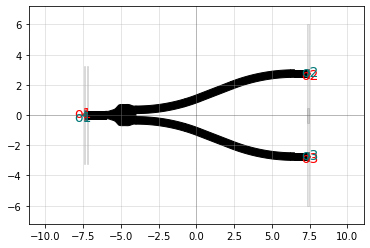

<Figure size 432x288 with 1 Axes>

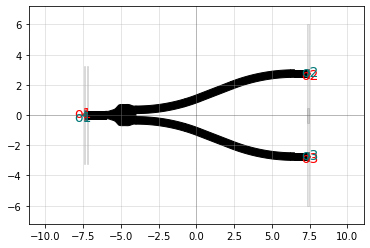

ebeam_y_1550_add_simula_67fad0c3: uid a5f8b964, ports ['o1', 'o2', 'o3'], references ['ebeam_y_1550_1'], 4 polygons

In [51]:
from gdsfactory.simulation.add_simulation_markers import add_simulation_markers
import ubcpdk as pdk
import sax

y = pdk.components.ebeam_y_1550()
y.unlock()
y.auto_rename_ports()
y = add_simulation_markers(y)
y

In [52]:
scene = y.to_3d()
scene.show()

trimesh: threejs viewer

## Circuit simulation


<Figure size 432x288 with 1 Axes>

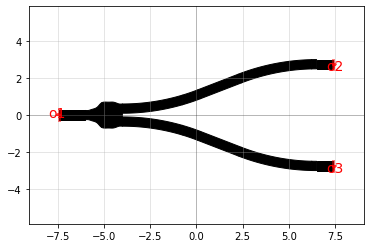

<Figure size 432x288 with 1 Axes>

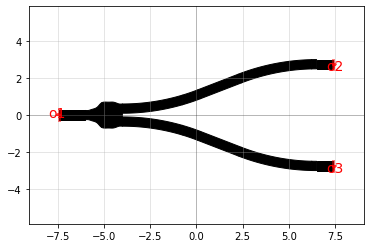

ebeam_y_1550: uid cf0e06a7, ports ['o1', 'o2', 'o3'], references [], 18 polygons

In [53]:
y = pdk.components.ebeam_y_1550()
y.unlock()
y.auto_rename_ports()
y

In [54]:
df = gm.write_sparameters_meep(y)

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep/__init__.py:4488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep.create_structure(cell_size, dft_data_list_, pml_1d_vols_, pml_2d_vols_, pml_3d_vols_, absorber_vols_, gv, br, sym, num_chunks, Courant, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_s, output_chunk_costs, my_bp)
/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep/__init__.py:4491: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._set_materials(s, cell_size, gv, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_geps, output_chunk_costs, my_bp)
2022-11-13 20:59:07.882 | INFO     | gdsfactory.simulation.gmeep

<Figure size 432x288 with 1 Axes>

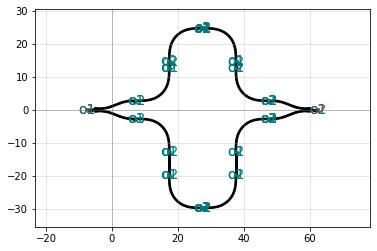

<Figure size 432x288 with 1 Axes>

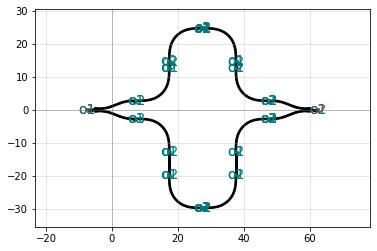

mzi_073734d6: uid fc667ec6, ports ['o1', 'o2'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_7', 'bend_euler_8', 'straight_8', 'straight_9', 'straight_10', 'sytl', 'syl', 'sxt', 'sxb', 'cp1', 'cp2'], 0 polygons

In [55]:
mzi10 = gf.components.mzi(splitter=y, delta_length=10)
mzi10

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from omegaconf import OmegaConf
import sax
from pprint import pprint

import gdsfactory as gf
import gdsfactory.simulation.sax as gsax
import gdsfactory.simulation.gmeep as gm

import ubcpdk as pdk

2022-11-13 21:37:27.592 | INFO     | gdsfactory.config:<module>:45 - Load '/usr/local/google/home/jmatres/gdsfactory/gdsfactory' 6.0.3
2022-11-13 21:37:29.067 | INFO     | gdsfactory.simulation.gmeep:<module>:32 - Meep '1.24.0' installed at ['/usr/local/google/home/jmatres/mambaforge/lib/python3.9/site-packages/meep']
2022-11-13 21:37:29.200 | INFO     | ubcpdk:<module>:36 - Found UBCpdk '1.8.0' installed at PosixPath('/usr/local/google/home/jmatres/ubc/ubcpdk')


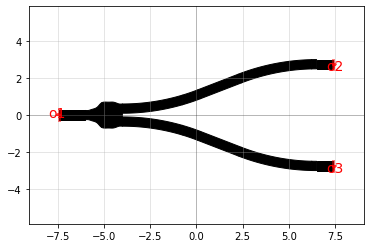

ebeam_y_1550: uid 4ae85580, ports ['o1', 'o2', 'o3'], references [], 18 polygons

In [2]:
y = pdk.components.ebeam_y_1550()
y.unlock()
y.auto_rename_ports()
y

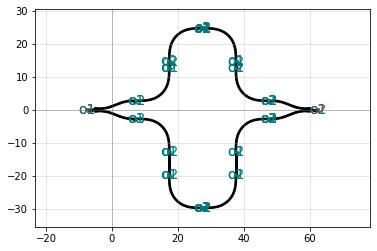

mzi_073734d6: uid e67dfef5, ports ['o1', 'o2'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_7', 'bend_euler_8', 'straight_8', 'straight_9', 'straight_10', 'sytl', 'syl', 'sxt', 'sxb', 'cp1', 'cp2'], 0 polygons

In [3]:
mzi = gf.components.mzi(splitter=y, delta_length=10)
mzi

In [4]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    wl0 = 1.5  # center wavelength for which the waveguide model is defined
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


In [5]:
sp = gm.write_sparameters_meep(y, run=True)
#ebeam_y_1550 = gsax.read.sdict_from_csv(filepath=df)
ebeam_y_1550 = gsax.read.model_from_npz(sp)

2022-11-13 21:37:30.170 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:341 - Simulation loaded from PosixPath('/usr/local/google/home/jmatres/ubc/sparameters/ebeam_y_1550_1f494ca0.npz')


In [6]:
type(sp)

numpy.lib.npyio.NpzFile

In [8]:
netlist = mzi.get_netlist()
circuit, _ = sax.circuit(
    netlist=netlist,
    models={
        "bend_euler": bend_euler,
        "ebeam_y_1550": ebeam_y_1550,
        "straight": straight,
    },
)

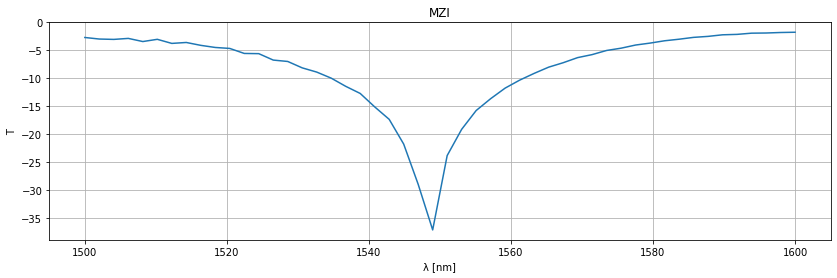

In [9]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)
plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, 10*np.log10(jnp.abs(S["o1", "o2"]) ** 2))
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

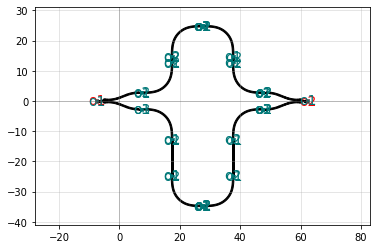

mzi_37692514: uid 6d60dae2, ports ['o1', 'o2'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_7', 'bend_euler_8', 'straight_8', 'straight_9', 'straight_10', 'sytl', 'syl', 'sxt', 'sxb', 'cp1', 'cp2'], 0 polygons

In [10]:
mzi = gf.components.mzi(splitter=y, delta_length=20)
mzi

In [12]:
netlist = mzi.get_netlist()
circuit, _ = sax.circuit(
    netlist=netlist,
    models={
        "bend_euler": bend_euler,
        "ebeam_y_1550": ebeam_y_1550,
        "straight": straight,
    },
)

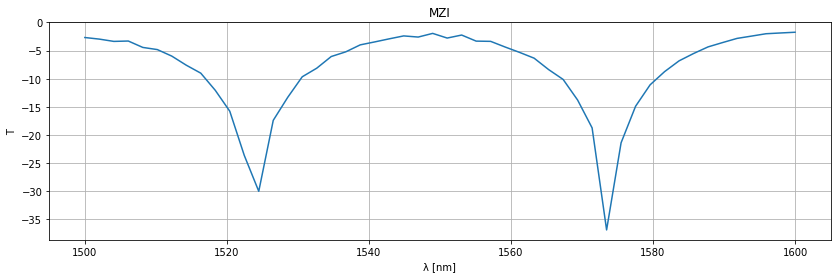

In [13]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)
plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, 10*np.log10(jnp.abs(S["o1", "o2"]) ** 2))
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()